In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

Undrift!

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
  7.0
 -3.0
 10.294644600835815
  9.06728457995035
 13.297424307537229
  7.461835328713278
 -4.1057654847011
  5.984560346803748
 -1.0250441859332582
 -6.632037492305164
  ⋮
  1.5711517472916254
 -1.4875633353312248
  3.072277083546592
  6.1284499471829275
  3.920853839141532
  5.235722599502449
  2.899488543618926
 10.550852167174481
 -0.5270158214029226

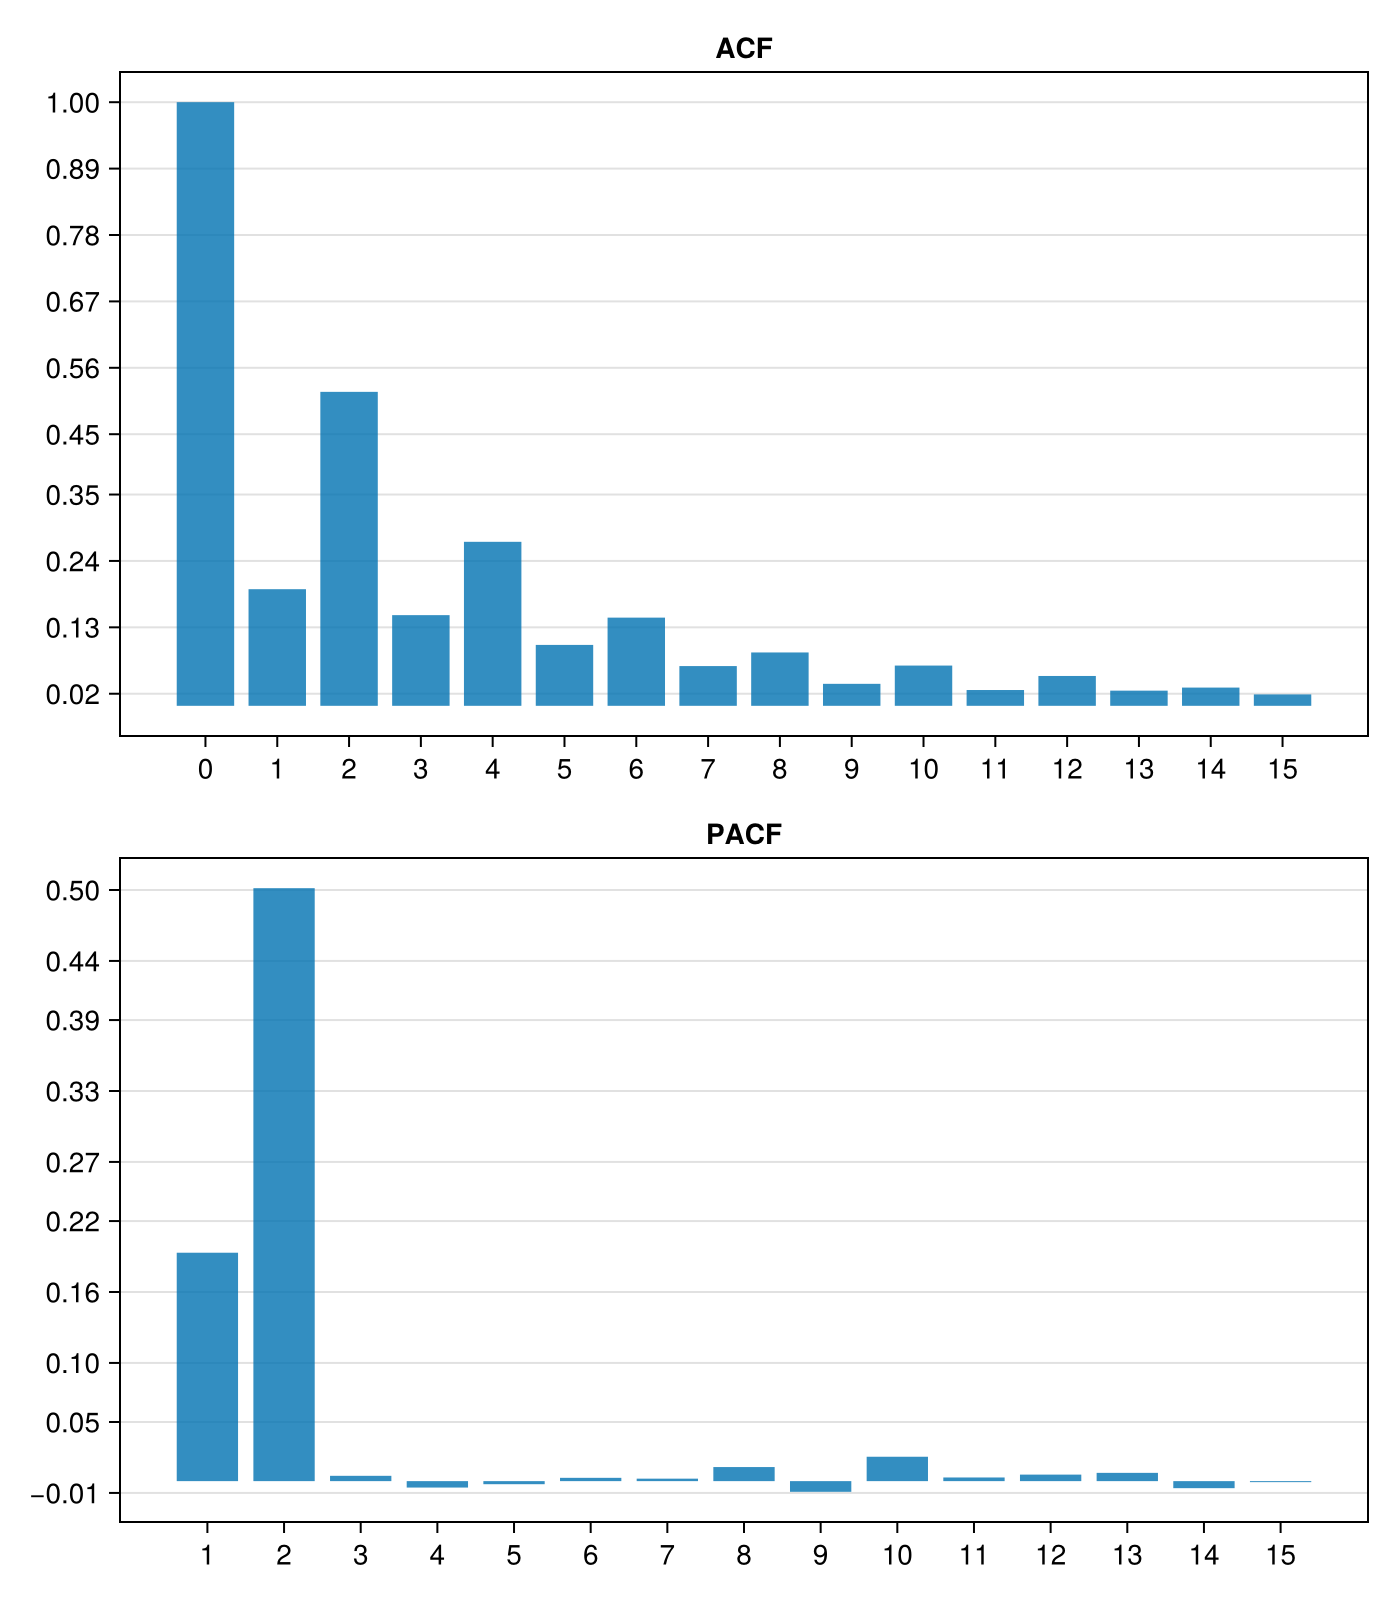

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.0034227,0.034227
2,Φ₂,0.00180932,0.00361863
3,σ,0.0178889,0.00298149


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

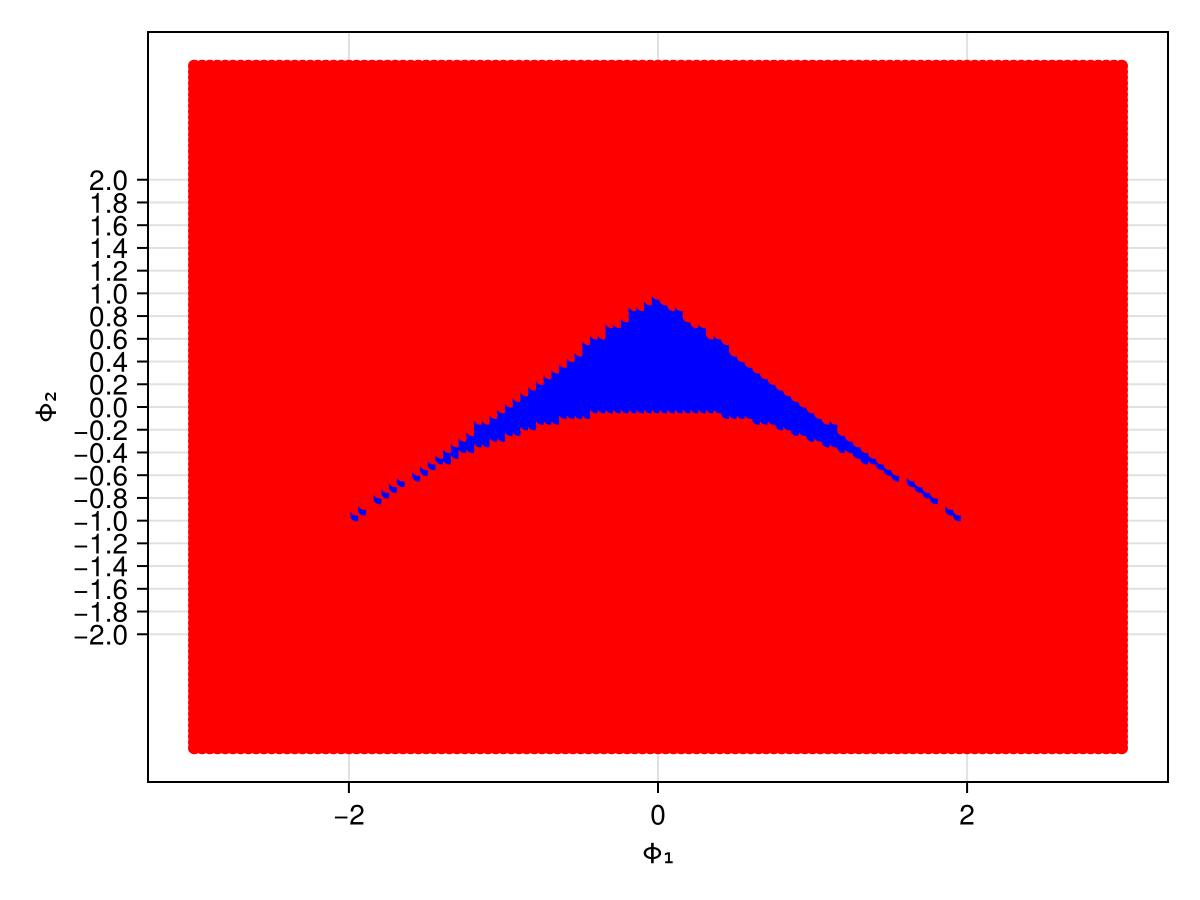

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[-4.844952276239293, -0.5797571903505121, -1.874967370448699, -1.115823504427106, 0.6731566489705769, 0.39969631206918554, 0.951131846511907, 1.7695012241563446, 2.050717112626499, 0.9484271815310782  …  0.10880270638374767, 1.4562783096859926, -0.29061868916904976, 1.5591372329561717, 2.343546000173854, 1.8869640308904585, -1.0790599330316186, -1.9372395631051256, -1.3751996077187303, -2.767333996510913], [-3.473131516955577, -1.797716053324508, -3.1760980502429925, -2.403043342622193, -4.0495970021850605, -2.1860116062597608, -2.2452989824196505, -2.1364427688656296, 0.4561223177676772, 0.35038300798545197  …  -3.184242652222666, -0.42122240749019646, -1.601510923404555, -0.7309761777882858, -0.5001491056379568, 0.7591357436857666, 0.5875945386467551, 1.0004495188754594, -1.7357538514565052, -0.5989581754541667], [-0.17756725779721316, 0.19126656625652083, -1.9322662357753726, 0.4626694641769513, 0.7910684289087657, 0.9527037692812956, -2.

## Autocorrelations

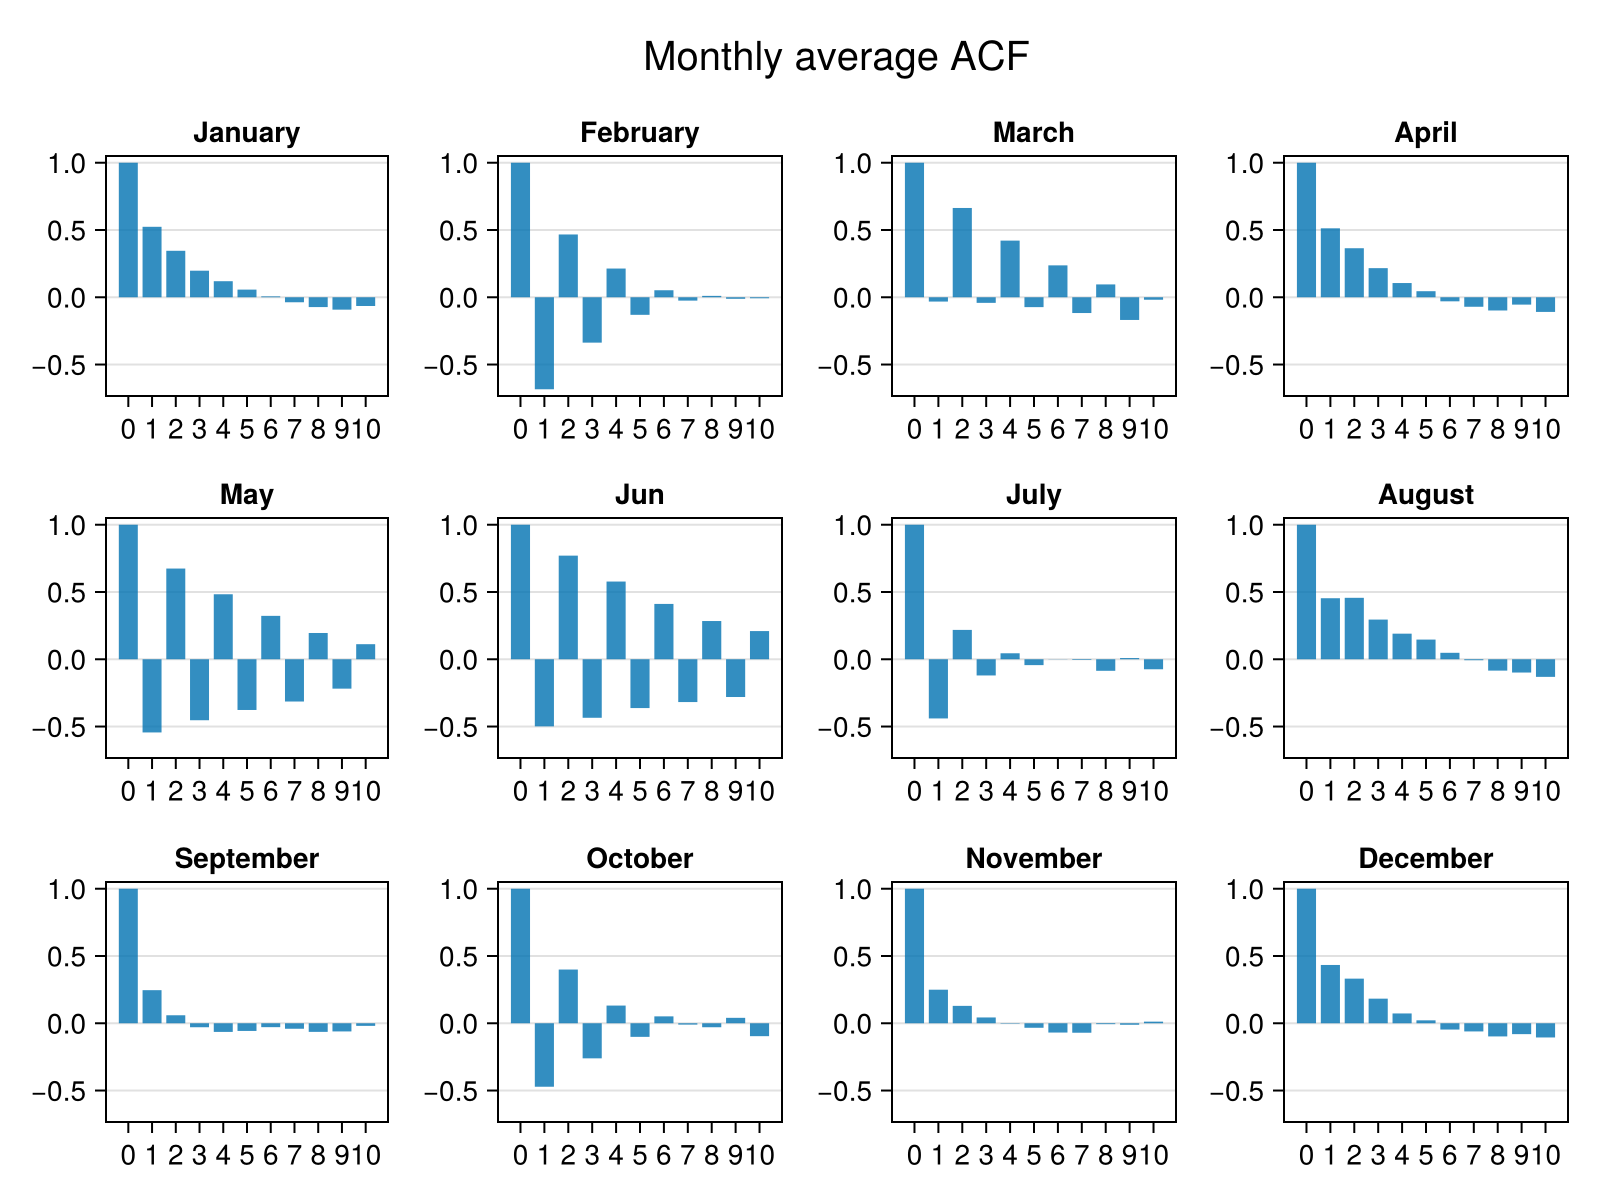

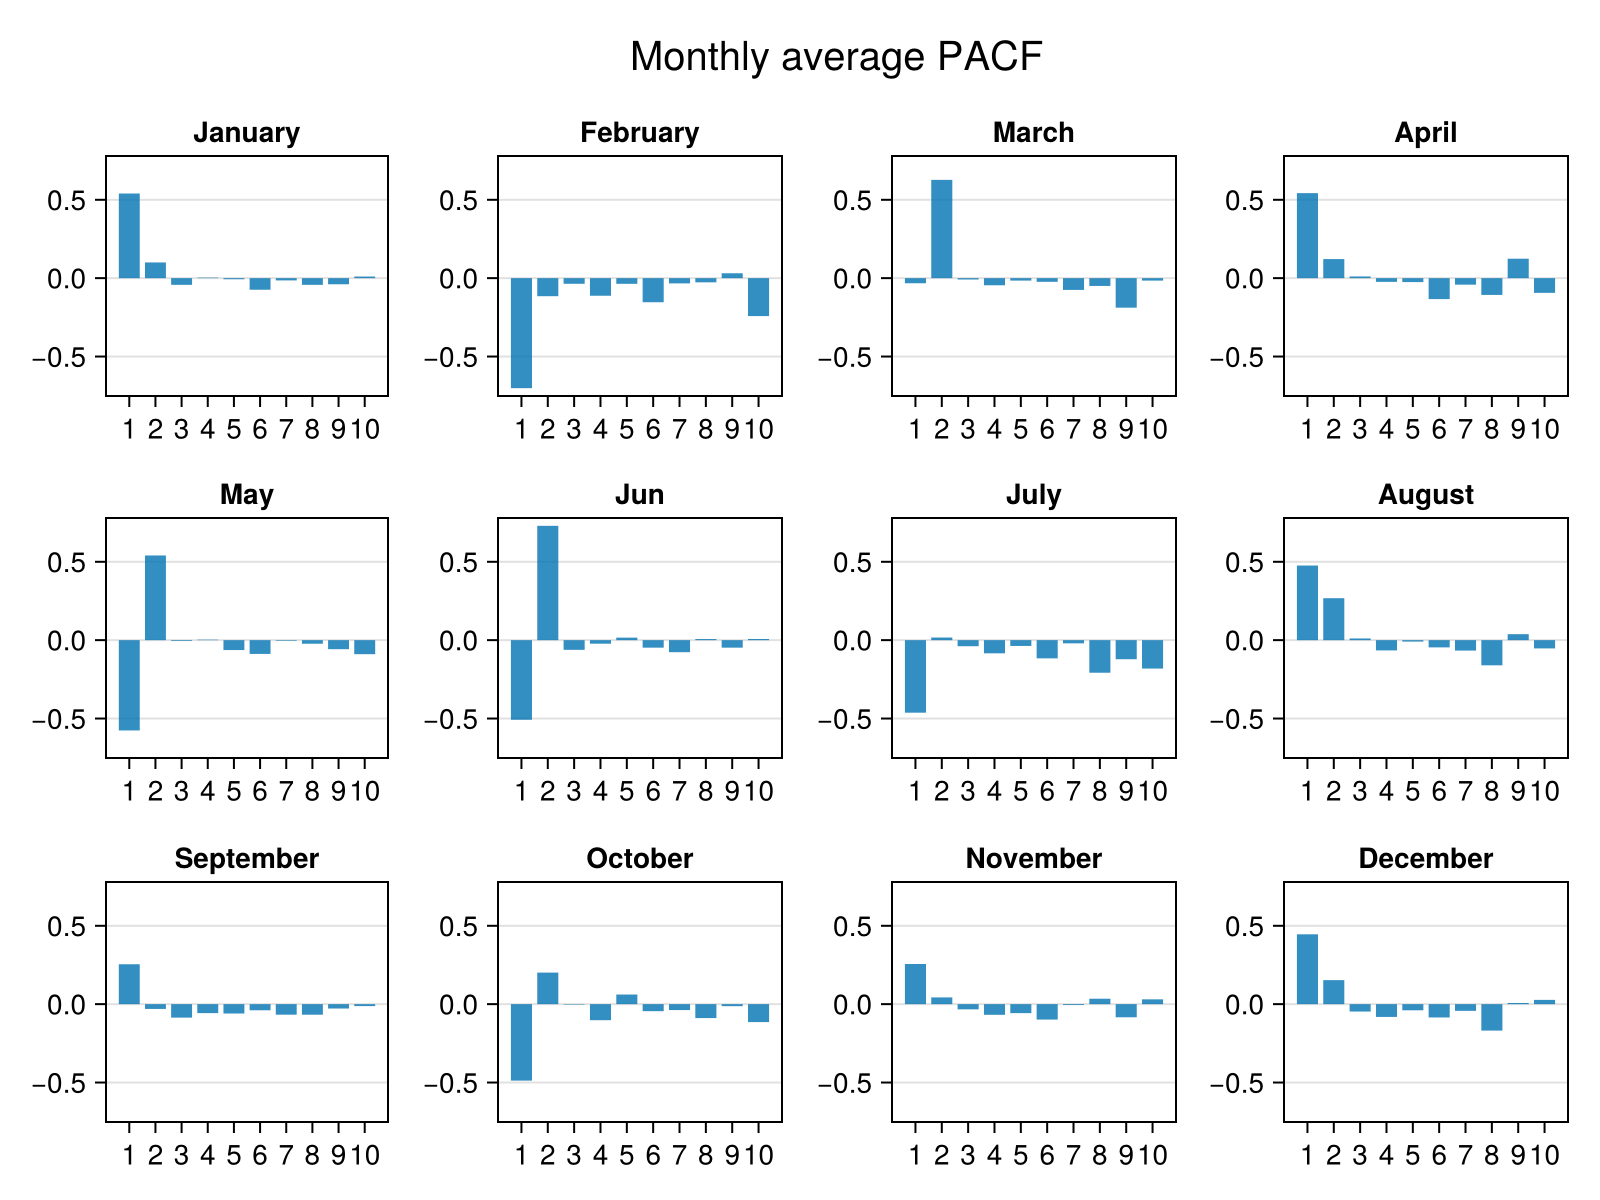

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

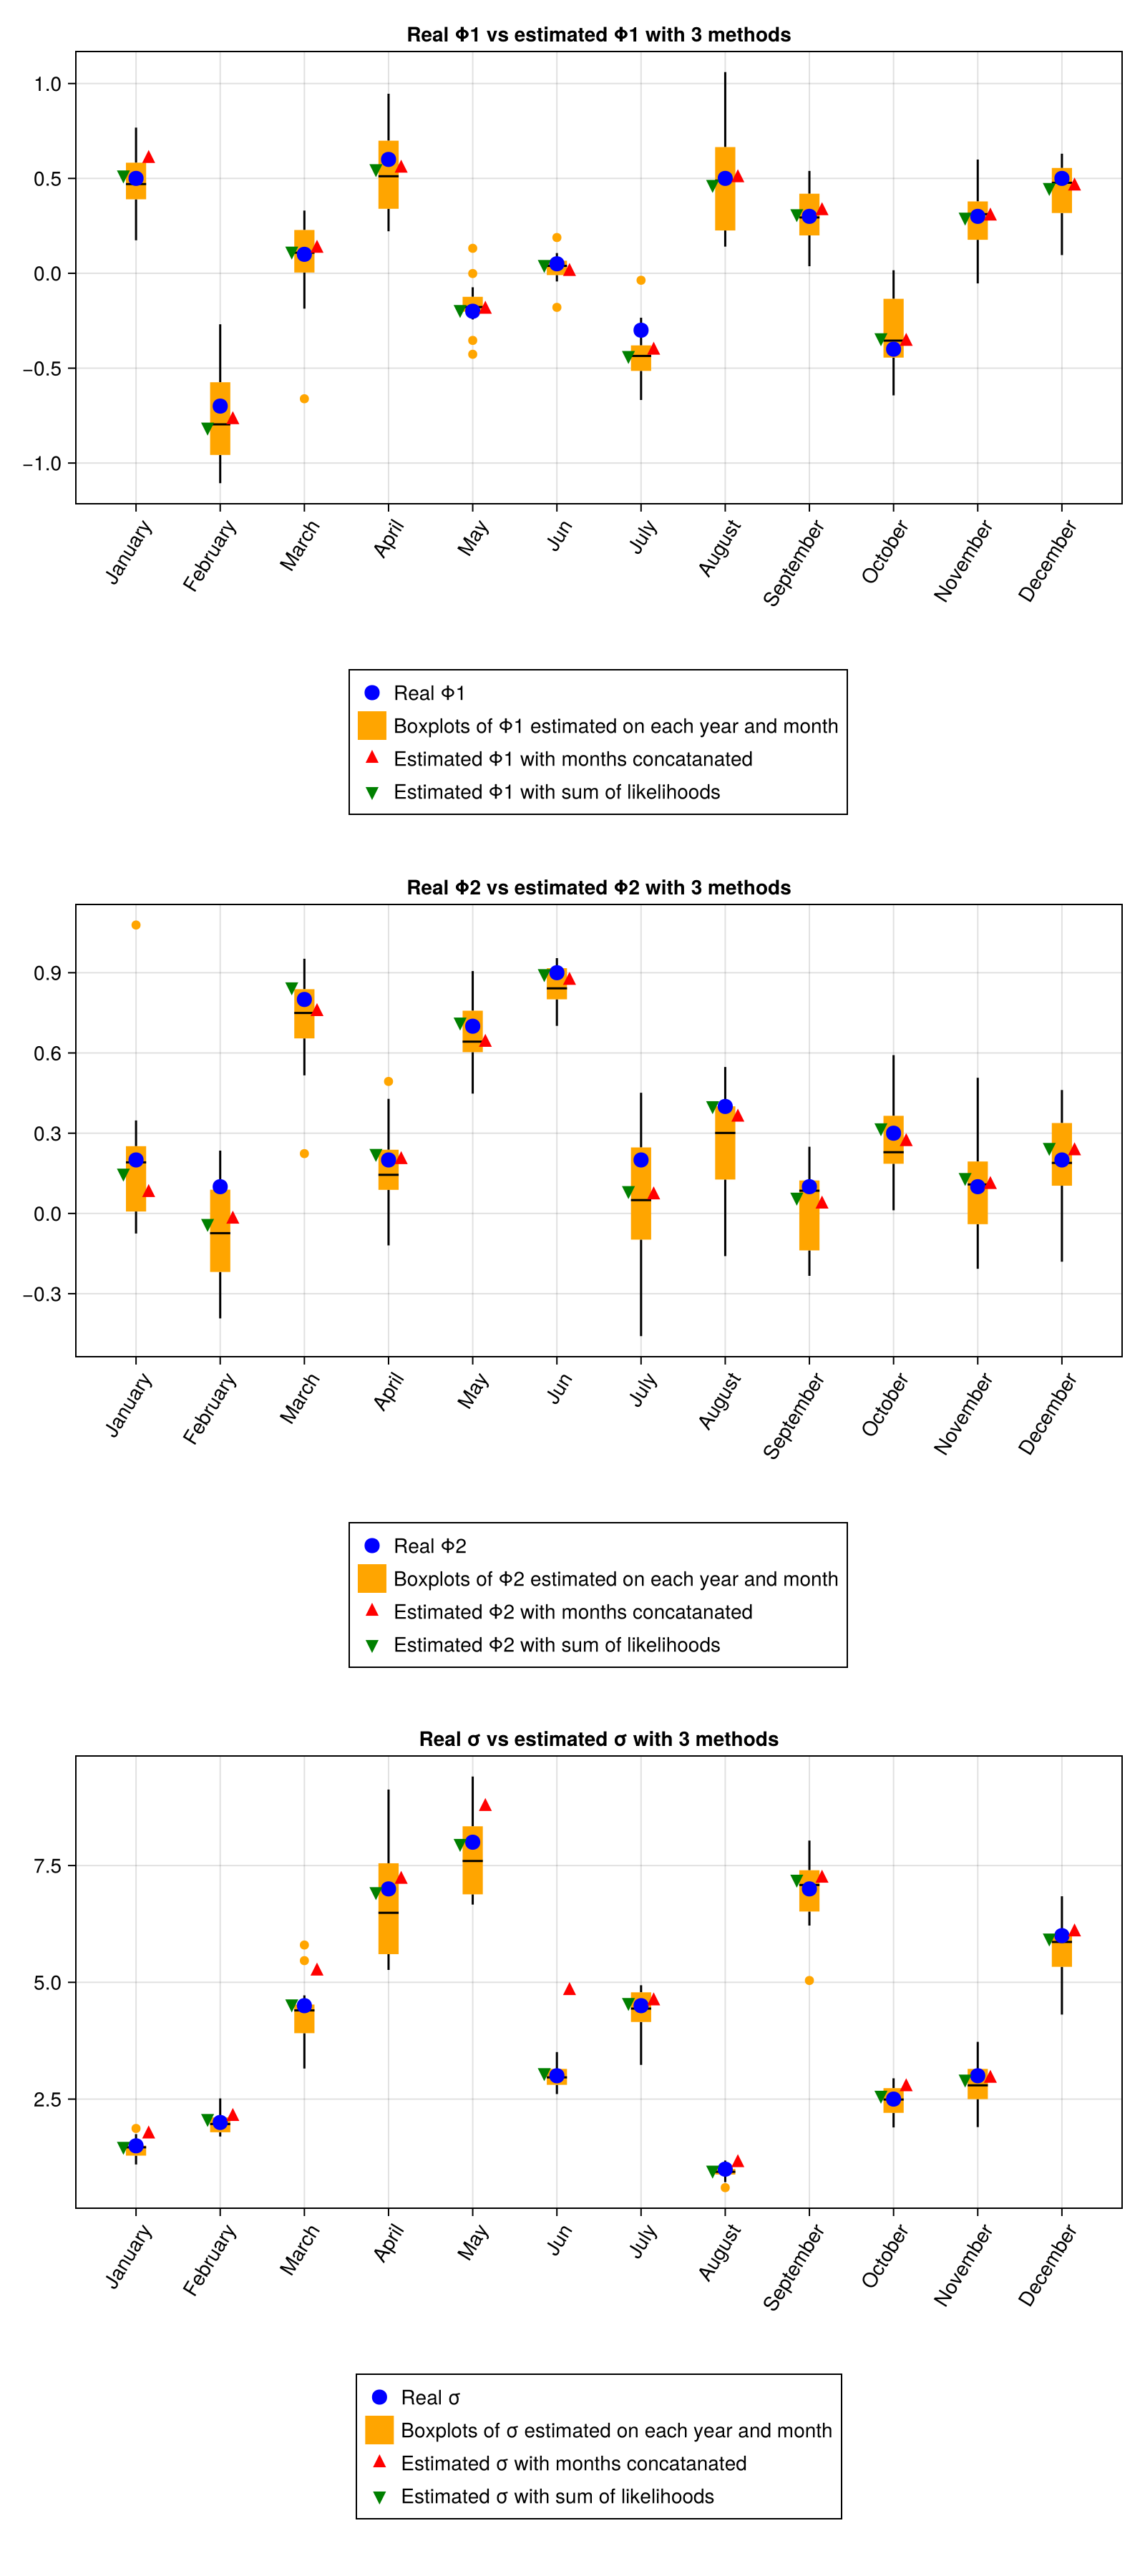

Row,Parameter,Month concatanation,Sum LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64
1,Φ1,18.4676,11.384,17.6868,12.1028
2,Φ2,31.4503,28.7003,35.4746,31.6294
3,σ,12.0978,1.84102,3.2998,3.09288


6

In [12]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [13]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=100
sim=SimulateYears([7.,4.],Date(2001,1,2),Φ_vec, σ_vec,n_years)
sample_=invert(sim)

365-element Vector{Vector{Float64}}:
 [7.0, -5.903046796359221, -8.158443061292505, -5.751626274437028, 1.693004317557956, 4.347956534089885, -6.750781120365188, 5.139577702584398, -6.9737575258821645, 4.488258109204187  …  -0.2529501721579758, 1.7698996676290295, -6.065605041868057, -7.044673209198307, -9.447481648855861, -5.591441941655553, 4.692384822203874, 3.6610108056769546, 5.410568848683134, 8.785684002616565]
 [4.0, -2.7548800686598844, -4.562727799193055, -4.458415147122268, 1.6246326620104772, 3.0569077510489464, -4.490090716456248, 4.163696280294209, -5.63662641405682, 0.9571918765463026  …  0.2814381374297457, 3.6067890880354607, -6.499977076779112, -5.591856715880643, -8.669738653182334, -2.6219345257723834, 0.4735142550001079, 4.574608883175925, 3.981275452800827, 5.377384618017783]
 [3.407506572158895, -2.212180931020611, -4.623806471520752, -3.2188625503896438, 2.354375939583674, 2.973239331337634, -5.508278488175568, 3.209305614788216, -1.1968952770729548, 1.329597101

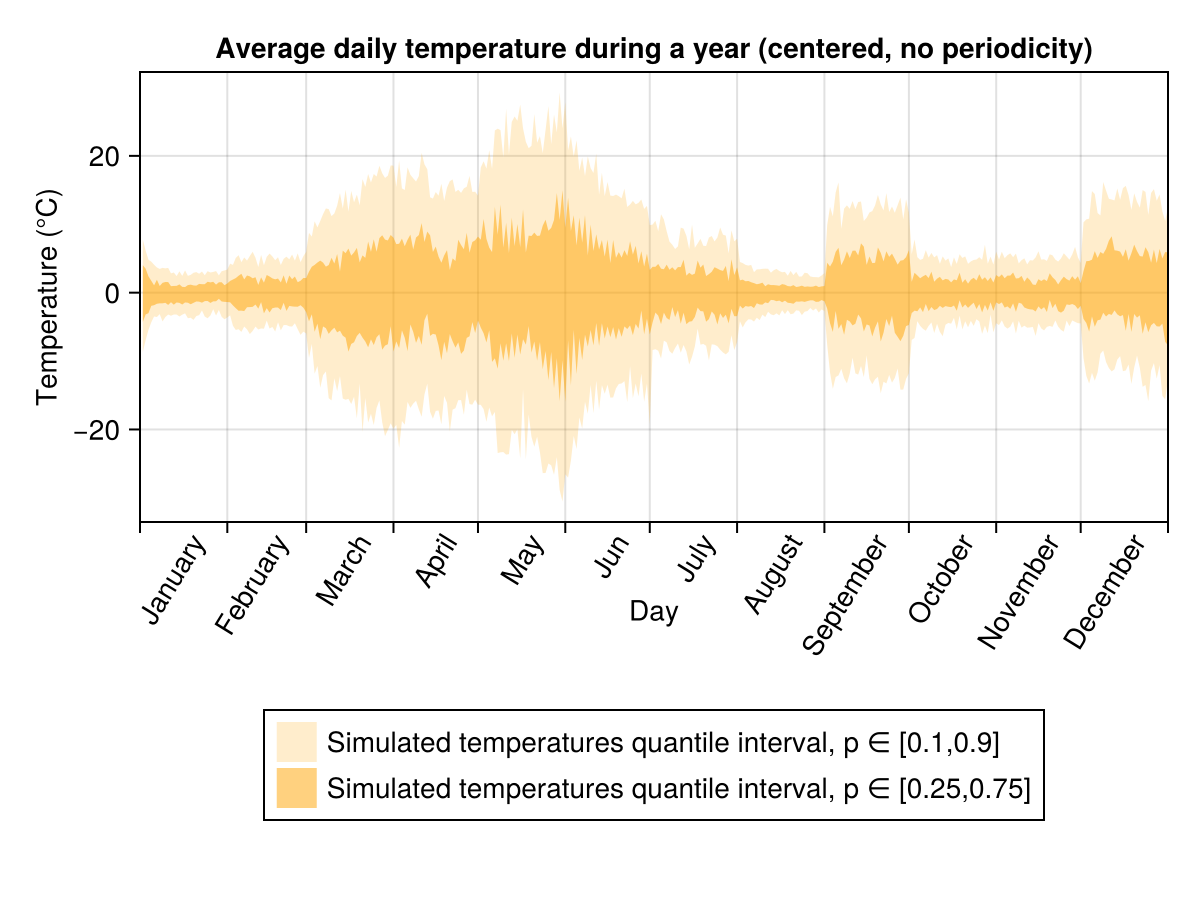

In [14]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)